In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power
from datetime import timedelta
def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Задание 3
**Срок сдачи: 07 апреля 18:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 бала). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 бала).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - сегмент пользователей

region - регион

category - категория авито

revenue_amount - сумма покупок


In [3]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date']=df.event_date.apply(date_converter)

### <b>1. Общая информация

In [4]:
df.head()

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160


In [5]:
df.columns = ['date', 'user_id', 'segment', 'category', 'region', 'revenue']

In [6]:
df['weekday'] = pd.DatetimeIndex(df['date']).weekday
df['week'] = df['date'].dt.isocalendar().week

In [7]:
df[['segment', 'category', 'region']]=df[['segment', 'category', 'region']].astype('str')

In [8]:
df.info()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8625842 entries, 0 to 8625841
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   user_id   int64         
 2   segment   object        
 3   category  object        
 4   region    object        
 5   revenue   int64         
 6   weekday   int64         
 7   week      UInt32        
dtypes: UInt32(1), datetime64[ns](1), int64(3), object(3)
memory usage: 501.8+ MB


0

In [9]:
df.nunique()

date            175
user_id     1932049
segment           3
category         33
region           84
revenue       15357
weekday           7
week             26
dtype: int64

In [10]:
df.date.min(), df.date.max()

(Timestamp('2019-06-18 00:00:00'), Timestamp('2019-12-09 00:00:00'))

In [11]:
df.segment.unique()

array(['4626944681007198896', '2376074197230840906', '853431062533847667'],
      dtype=object)

### <b> 2. Подготовка данных

In [12]:
def line_plot(data, x=None, y=None, hue=None, title=None):
    # Функция рисует линейный график по данным data
    plt.figure(figsize=(16, 9))
    ax = sns.lineplot(y=y, x=x,  data=data, hue=hue)
    ax.set_title(title)
    plt.show()
    
def count_plot(data, x=None, y=None, hue=None, title=None):    
    plt.figure(figsize=(16, 9))
    ax = sns.countplot(x=x, hue=hue, data=data, dodge=False, alpha=0.3)
    ax.set_title(title)
    plt.show()

In [13]:
dfg_dates = df.groupby(['date', 'category', 'segment'])[['user_id', 'revenue']].agg({'user_id':'count', 'revenue': np.sum}).reset_index(drop=False)
dfg_dates['weekday'] = pd.DatetimeIndex(dfg_dates['date']).weekday
dfg_dates['week'] = dfg_dates['date'].dt.isocalendar().week
dfg_dates.rename(columns={"user_id": "count"}, inplace=True)
dfg_dates.fillna(0, inplace=True)


In [14]:
dfg_dates.tail()

,date,category,segment,count,revenue,weekday,week
16148,2019-12-08,7948270325129383019,853431062533847667,490,500969,6,49
16149,2019-12-08,91460430793700892,2376074197230840906,173,75628,6,49
16150,2019-12-08,91460430793700892,4626944681007198896,721,193451,6,49
16151,2019-12-08,91460430793700892,853431062533847667,56,41685,6,49
16152,2019-12-09,1472231361867825698,4626944681007198896,1,91,0,50


In [15]:
dfg_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16153 entries, 0 to 16152
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      16153 non-null  datetime64[ns]
 1   category  16153 non-null  object        
 2   segment   16153 non-null  object        
 3   count     16153 non-null  int64         
 4   revenue   16153 non-null  int64         
 5   weekday   16153 non-null  int64         
 6   week      16153 non-null  UInt32        
dtypes: UInt32(1), datetime64[ns](1), int64(3), object(2)
memory usage: 836.2+ KB


In [16]:
dfg_dates.nunique()

date          175
category       33
segment         3
count        2544
revenue     15134
weekday         7
week           26
dtype: int64

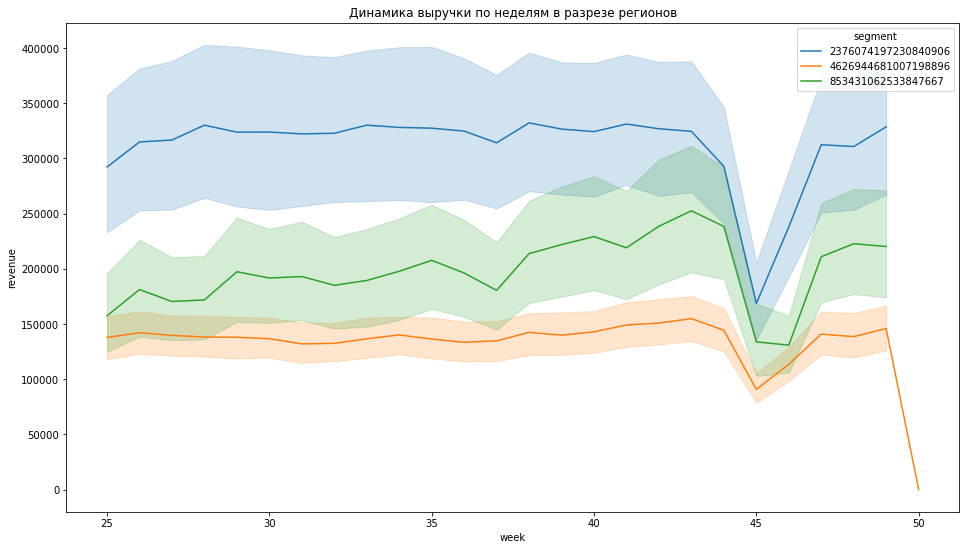

In [17]:
# Посмотрим на распределение динамику прибыли 
line_plot(y=dfg_dates.revenue, 
          x=dfg_dates.week,  
          data=dfg_dates, 
          hue='segment', 
          title='Динамика выручки по неделям в разрезе регионов')

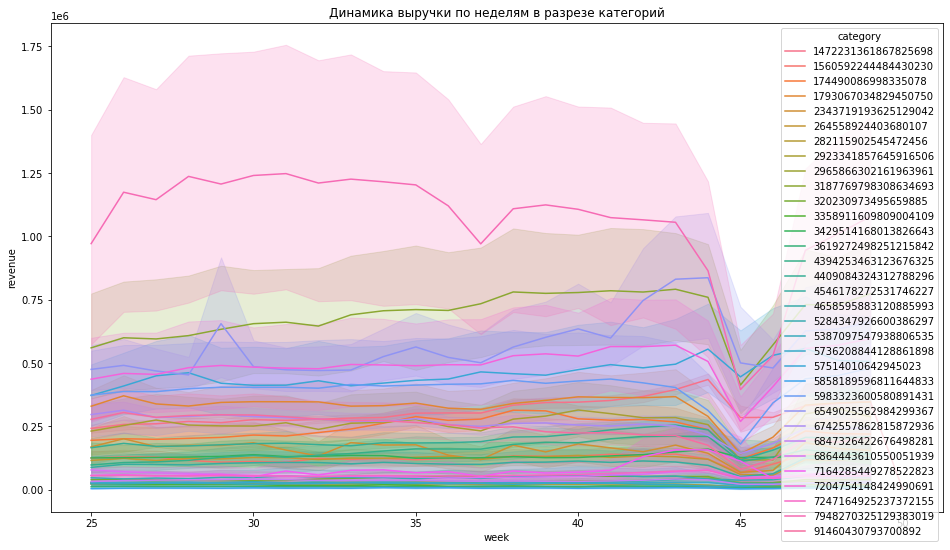

In [18]:
# Посмотрим на динамику прибыли по категориям
line_plot(y=dfg_dates.revenue, 
          x=dfg_dates.week,  
          data=dfg_dates, 
          hue='category', 
          title='Динамика выручки по неделям в разрезе категорий')

Наблюдаем равномерную динамику выручки по неделям за исключением периода в начале ноября. Можно предположить, что это связано со сбоем в приложении. 
Также присутствует сильная недельная сезонность

In [19]:
dfg = df.groupby(['category', 'region', 'segment'])[['user_id', 'revenue']].agg({'user_id':'count', 'revenue': np.mean}).reset_index(drop=False)
dfg.rename(columns={"user_id": "count"}, inplace=True)
dfg.head()

,category,region,segment,count,revenue
0,1472231361867825698,1046676874565143364,2376074197230840906,1163,174.700774
1,1472231361867825698,1046676874565143364,4626944681007198896,3370,97.298813
2,1472231361867825698,1046676874565143364,853431062533847667,197,667.741117
3,1472231361867825698,1103602596183811891,2376074197230840906,19,69.315789
4,1472231361867825698,1103602596183811891,4626944681007198896,471,102.883227


<AxesSubplot:xlabel='count', ylabel='revenue'>

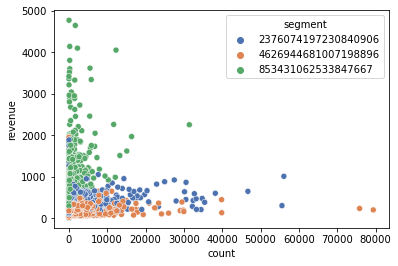

In [20]:
sns.scatterplot(data=dfg, y='revenue', x="count", hue="segment", palette="deep")

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Количество сделок по сегментам')

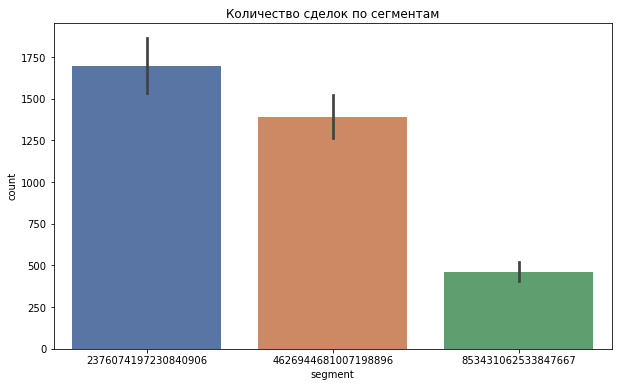

In [21]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=dfg, y='count', x="segment", palette="deep")
ax.set_title('Количество сделок по сегментам')
plt.show()

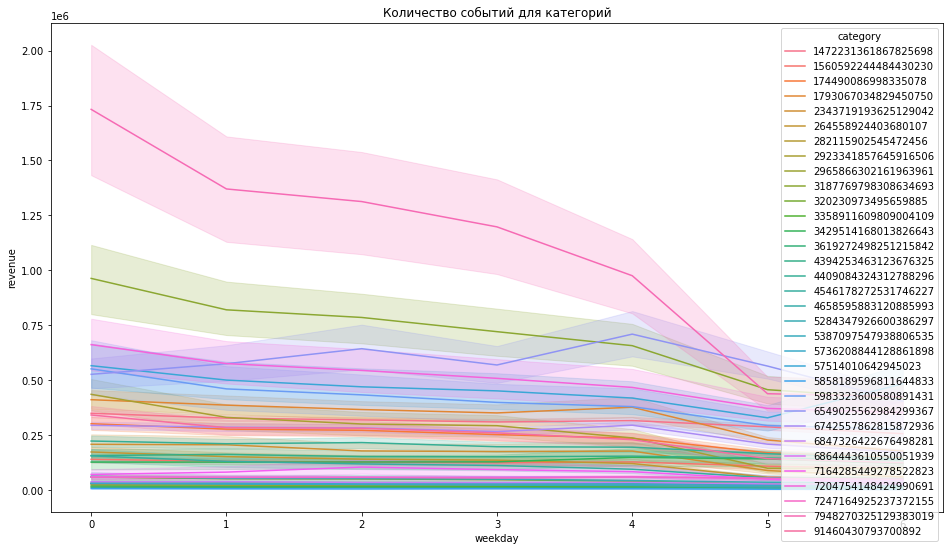

In [22]:
# Посмотрим на распределение прибыли по дням недели
line_plot(y=dfg_dates.revenue, x=dfg_dates.weekday,  data=dfg_dates, hue='category', title='Количество событий для категорий')

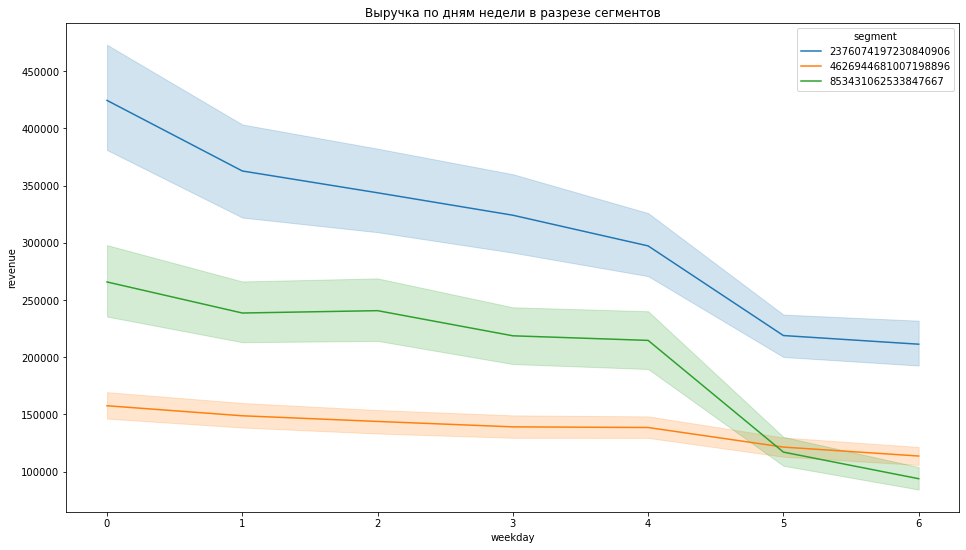

In [23]:
# Посмотрим на распределение прибыли по дням недели
line_plot(y=dfg_dates.revenue, 
          x=dfg_dates.weekday,  
          data=dfg_dates, 
          hue='segment', 
          title='Выручка по дням недели в разрезе сегментов')

Основная выручка приходится на будние дни

In [24]:
def calc_stsc(df, col):
    temp = df.groupby([col, 'user_id'])[['revenue']].agg([np.sum]).reset_index(drop=False)
    temp= temp.groupby([col])[[('revenue', 'sum')]].agg([np.mean, np.std]).reset_index(drop=False)
    temp.columns = [col, 'mean', 'std']
    return temp

In [25]:
stat={}
for col in ['category', 'region', 'segment']:
    stat[col] = calc_stsc(df, col)

In [26]:
stat['segment'].head()
stat['region'].head()
stat['category'].head()

,segment,mean,std
0,2376074197230840906,2493.691418,9820.731918
1,4626944681007198896,519.322613,1577.740638
2,853431062533847667,48775.231909,164513.128251


,region,mean,std
0,1046676874565143364,1296.755094,8959.943741
1,1103602596183811891,611.899168,2878.749072
2,1116465816370945844,1716.071246,11618.146052
3,1187552825302355021,705.172376,3057.408560
4,1282872640859057241,1059.006608,6146.516254


,category,mean,std
0,1472231361867825698,679.799879,9038.733455
1,1560592244484430230,834.321764,4359.805621
2,174490086998335078,825.001697,8233.668747
3,1793067034829450750,1756.367168,14685.563176
4,2343719193625129042,4687.107884,26156.828325


Средняя прибыль по категориям, сегментам и регионам сильно отличается. Стандартное отклонение также сильно колеблется

**Предскажите минимально детектируемый эффект (MDE) 2 балла:**
<br>Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;

In [27]:
def calc_nobs(df, share=0.5, days=90):
    start_day = df.date.min()
    end_day = start_day + timedelta(days)
    nobs = int(df[(df.date >= start_day) & (df.date <= end_day)].user_id.nunique() * share / 2)
    return nobs

In [28]:
# Посчитаем mde для разных параметров share и количества дней теста
df_std = df.groupby(['user_id'])[['revenue']].agg([np.sum]).reset_index(drop=False)
mean = df_std.mean()[('revenue', 'sum')]
std = df_std.std()[('revenue', 'sum')]
alpha = 0.01
power = 0.8
share_list = [0.1, 0.25, 0.5]
days = [30, 60, 90]

In [29]:
predict = []
for share in share_list:
    for n in days:
        nobs = calc_nobs(df, share=share, days=n)
        mde = tt_ind_solve_power(alpha=alpha, power=power, nobs1=nobs)
        predict.append([share, n, mde*std])
predict   

[[0.1, 30, 535.8884876394075],
 [0.1, 60, 432.00707479236036],
 [0.1, 90, 377.4149484530536],
 [0.25, 30, 338.93484165543043],
 [0.25, 60, 273.1902547294677],
 [0.25, 90, 238.69421201682417],
 [0.5, 30, 239.66133473158692],
 [0.5, 60, 193.17703525622665],
 [0.5, 90, 168.78259163830998]]

In [30]:
# Средняя выручка
mean

1789.8822597149451

В лучшем случае при проведении теста на 50% пользователей мы можем расчитывать на минимальный детектируемый эффект не менее 168 (руб.?), так как выручка получается слишком шумная метрика.

In [31]:
df_std[('revenue', 'sum')].median()

245.0

In [32]:
df_week_std = df.groupby(['week', 'user_id'])[['revenue']].agg(np.sum).reset_index()
df_week_std = df_week_std.groupby(['week'])[['revenue']].agg(np.std).reset_index()
df_week_std.columns = ['week', 'revenue_std']
df_week_std.head()

,week,revenue_std
0,25,1957.306282
1,26,3156.569960
2,27,2363.454419
3,28,2315.407526
4,29,3284.948410


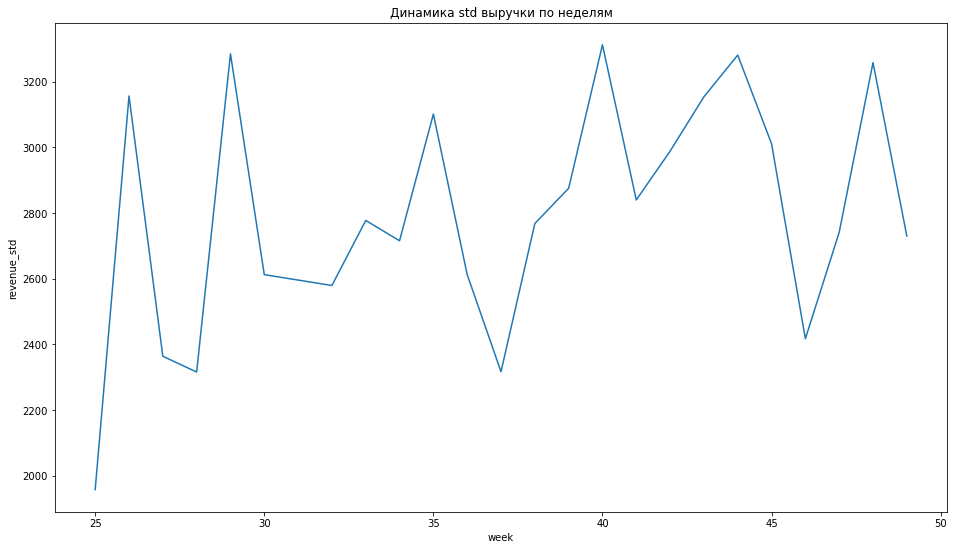

In [33]:
# Посмотрим на динамику std выручки по неделям
line_plot(y=df_week_std.revenue_std, 
          x=df_week_std.week,  
          data=df_week_std, 
          title='Динамика std выручки по неделям')

Дисперсия по неделям изменяется довольно значительно, но явного тренда на рост или снижение дисперсии не наблюдается.

In [34]:
len(df.user_id)/df.user_id.nunique()

4.464608299271913

In [35]:
def std_days(df, n):
    start_day = df.date.min()
    std = {}
    for days in range(n):
        end_day = start_day + timedelta(days)
        std[days] = np.std(df[(df.date >= start_day) & (df.date <= end_day)].revenue)
    return pd.DataFrame(data={'days':std.keys(),  'std':std.values()})

In [36]:
df_std = std_days(df, 90)

<AxesSubplot:>

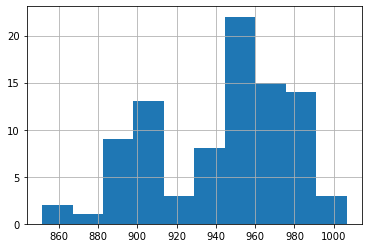

In [37]:
df_std['std'].hist()

<AxesSubplot:xlabel='days', ylabel='std'>

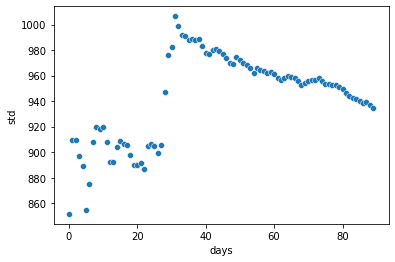

In [38]:
sns.scatterplot(data=df_std, x="days", y="std")

В целом не считая всплеска на 30-35 день можно сделать вывод о том, что дисперсия выручки снижается с ростом числа наблюдений, следовательно стоит брать пред период равным тестовому.

In [39]:
df_weekday_std = df.groupby(['weekday', 'user_id'])[['revenue']].agg(np.sum).reset_index(drop=False)
df_weekday_std = df_weekday_std.groupby(['weekday'])[['revenue']].agg(np.std).reset_index(drop=False)
df_weekday_std.columns = ['weekday', 'revenue_std']

<AxesSubplot:xlabel='weekday', ylabel='revenue_std'>

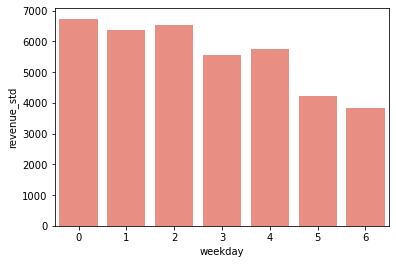

In [40]:
# Посмотрим на динамику std
sns.barplot(x="weekday", y="revenue_std", data=df_weekday_std, color="salmon")

Так как дисперсия распределена неравномерно по дням недели, т.е. имееет недельную цикличность, то для тестирования логично использовать периоды кратные неделям.

In [141]:
def merge_samples(before, after):
    after = after.merge(before, on='user_id', suffixes=('_after', '_before'), how='left')
    return after.dropna()
    
def get_cuped(before, after):
    # Расчет cuped и оценка снижения дисперсии     
    tmp = merge_samples(before, after)
    mean_before = np.mean(tmp.revenue_before)
    a = tmp[tmp.group_before == 'A']
    b = tmp[tmp.group_before == 'B']
    cv = np.cov([a.revenue_after, a.revenue_before])
    theta = cv[0, 1] / cv[1, 1]
    
    cuped = b.revenue_after - (b.revenue_before - np.mean(b.revenue_before)) * theta
    return 1 - np.corrcoef(tmp.revenue_after, tmp.revenue_before)[1,0]**2

def get_samples(data, min_date, max_date, a_share=0.5, b_share=0.5):
    df_samples = data[(data.date >= min_date) & (data.date < max_date)]
    df_samples = df_samples.groupby(['user_id'])[['revenue']].sum().reset_index()
    samplesA = pd.DataFrame(df_samples[df_samples.user_id % 100 < 100 * a_share])
    samplesA['group'] = 'A'
    samplesB = pd.DataFrame(df_samples[df_samples.user_id % 100 > 100 * (1 - b_share)])
    samplesB['group'] = 'B'
    return pd.concat([samplesA, samplesB], ignore_index=True)

def calc(border_day, days_before=30, days_after=30):
    before = get_samples(df, border_day -  timedelta(days_before), border_day)
    after = get_samples(df, border_day, border_day + timedelta(days_after))
    return get_cuped(before, after)

In [142]:
start = datetime.datetime(2019, 7, 20,0,0,0)
dates = [start + timedelta(test*7)  for test in range(18)]
effect = {d:calc(d) for d in dates}

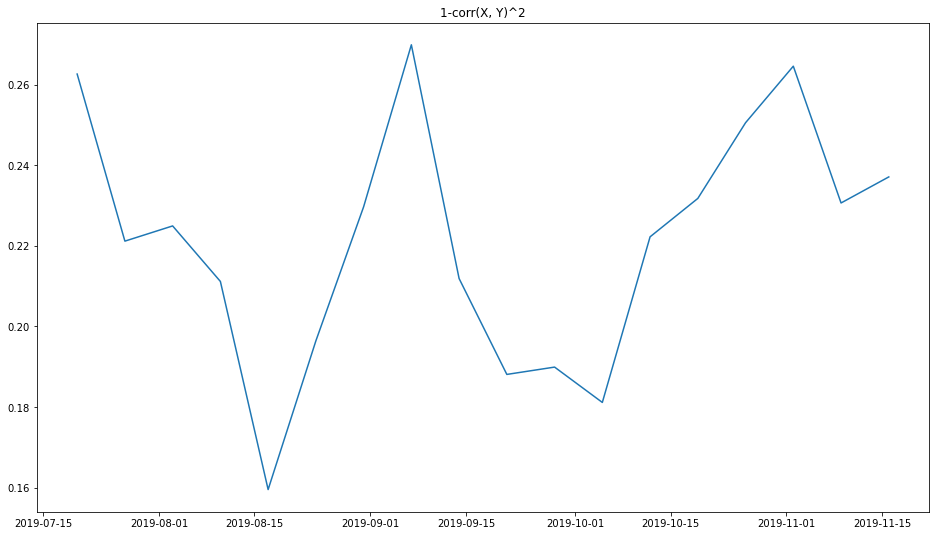

In [144]:
line_plot(y=list(effect.values()), 
          x=list(effect.keys()),  
          data=effect, 
          title='1-corr(X, Y)^2')

При применении CUPED позволяет снизить дисперсию в среднем в 4-6 раз.

In [120]:
start = datetime.datetime(2019, 8, 17, 0,0,0)
effect = {d:calc(start, days_before=d) for d in range(1, 45)}

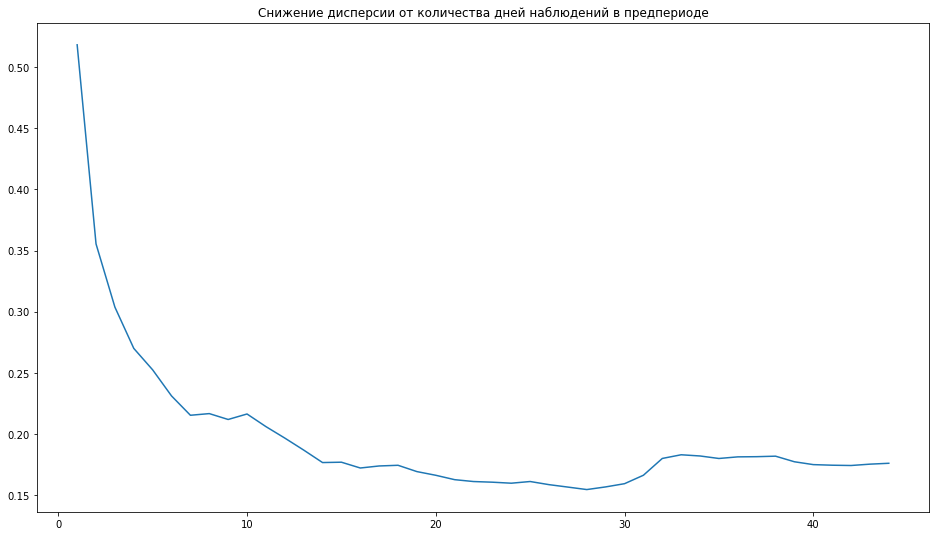

In [121]:
line_plot(y=list(effect.values()), 
          x=list(effect.keys()),  
          data=effect, 
          title='Снижение дисперсии от количества дней наблюдений в предпериоде')

Для практических целей количество дней в предпериоде можно брать не более 20-30, затем ощутимого снижения дисперсии уже не происходит